# 1. Importing required libraries

In [21]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from warnings import filterwarnings

filterwarnings(action='ignore')

import os

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error

<!--  -->

# 2. Importing observation, reanalysis data and verifying required specifications

<!--  -->

## 2.1 Import

In [22]:
def import_obs_windspeed_reanalysis():
    
    """
    
    Function imports observation and reanalysis data placed in the directory/ folder
    
    Output:
    
    1. obs_data: (pandas DataFrame object)
    
    2. reanalysis_data: (pandas DataFrame object)
    
    """
    # Observation data
    
    try:

        obs_data = pd.read_csv('obs_data.csv',index_col=0, parse_dates=True).iloc[:-15:]

        # Sorting based on datetime index

        obs_data = obs_data.sort_index()

        obs_data.columns = ['windspeed',]

        obs_data.index.name = 'DATE'
    
    except:
        
        obs_data = None
        
    # Reanalysis data
    
    try:

        reanalysis_data = pd.read_csv('reanalysis_data.csv',index_col=0, parse_dates=True)

        # Sorting based on datetime index

        reanalysis_data = reanalysis_data.sort_index()

        reanalysis_data.index.name = 'DATE'

        reanalysis_data.columns = [col.lower() for col in reanalysis_data.columns]
    
    except:
        
        reanalysis_data = None
        
    return obs_data, reanalysis_data

## 2.2 Verifying required specifications

In [23]:
def verify_required_specifications_obs_data(df):
            
    """
    
    Function, verifies whether the observation wind speed data meets the required criteria.
    
    Input:
    
    df (pandas DataFrame object)
    
    Output:
    
    df (pandas DataFrame object)
    
    """
    
    df = df.resample('D').mean().dropna()
    
    # Only considering data after 1958-01-01
    
    df = df[df.index >= '1958-01-01']    
    
    if len(df) < 600:
        
        return None        
    
    else:
        
        return df        
        
    
def filter_windspeed_from_outliers(df):
    
    """
    Filters nan values and outliers (above or below 1.5 times IQR (Inter quartile range)).
    
    Input:
    
    df (pandas DataFrame object)
    
    Output:
    
    df (pandas DataFrame object)

    """
        
    _, bp_data = df.loc[:,['windspeed',]].boxplot(return_type='both')

    whiskers = [whiskers.get_ydata()[1] for whiskers in bp_data["whiskers"]]

    ulimit = whiskers[1]

    llimit = whiskers[0]
    
    plt.close()
    
    return df.loc[(df['windspeed'] <= ulimit) &  (df['windspeed'] >= llimit),:]



In [24]:
# Processing

def verify_required_specifications_reanalysis_data(df,last_date_index):
    
    """
    Function checks if the reanalysis data provided meets the required criteria
    
    Input:
    
    df: reanalysis data (pandas DataFrame object)
    
    last_date_index: last timestamp of observation data (pandas Timestamp object or str ('YYYY-MM-DD'))
    
    Output:
    
    df: Processed reanalysis data (daily average + nan features dropped + column names changed to lower case) (pandas DataFrame object)
        (pandas DataFrame object)
    
    error_msg: (str)
    
    """
    
    # Cropping data
    
    error_msg = ''
    
    bool_lst = []

    df = df.resample('D').mean()
    
    df = df[~df.isna().all(axis=1)]
    
    df = df.loc[((df.index >= '1958-01-01') & (df.index <= last_date_index)),:]
    
    # Condition 1: Reanalysis data should not have missing data-points (rows)
    
    req_length = len(pd.date_range('1958-01-01',last_date_index,freq='D'))
    
    if len(df) < req_length:

        error_msg = error_msg + "Condition 1: Reanalysis data should not have missing data-points (failed)\n"
        
        bool_lst.append(False)
    
    else:
        
        bool_lst.append(True)
        
    # Condition 2: Checking number of features
    
    df = df.loc[:,df.columns[~df.isna().all(axis=0)]]
    
    req_nfeatures = 10
    
    if len(df.columns) < 10:

        error_msg = error_msg + f"Condition 2: Number of features should be at least {req_nfeatures} (failed)\n"
        
        bool_lst.append(False)
    
    else:
        
        bool_lst.append(True)
        
    # Condition 3: Compulsory features wind_era5, wind_jra55, wind_ncep1
    
    # Changing columns to lower case
    
    df.columns = [col.lower() for col in df.columns]
    
    compulsory_features = ['wind_era5','wind_jra55','wind_ncep1']

    found = True

    for cfeature in compulsory_features:

        if not (cfeature in df.columns):

            found = False

            break

    if not found:

        error_msg = error_msg + f"Condition 3: Necessary features available in reanalysis data provided (failed)\n"

        bool_lst.append(False)

    else:

        bool_lst.append(True)
        
    if all(bool_lst):
        
        return df, error_msg
    
    else:
        
        return None, error_msg
        
    

## 2.3 Main function

In [25]:
def main_function_1_import_verify():
    
    """
    Function perfroms two tasks: 
    
    1.imports observation and reanalysis data placed in the directory/ folder. 
    
    2.Verifies if the required criteria and satisfied. 
    
    Output:
    
    obs_data: (pandas DataFrame object)
    
    reanalysis_data: (pandas DataFrame object)
    
    """    
    
    
    obs_data, reanalysis_data = import_obs_windspeed_reanalysis()    
        
    if obs_data is None:
                
        print("Error in importing observation data\n")
    
    else:
        
        obs_data = verify_required_specifications_obs_data(obs_data)
        
        if obs_data is None:
            
            print("Observation data fails to meet the required criteria of at least 600 data-points\n")
            
        else:
            
            obs_data = filter_windspeed_from_outliers(obs_data)
            
            last_date_index = obs_data.index[-1]
    
            if reanalysis_data is None:

                print("Error in importing reanalysis data\n")

            else:

                reanalysis_data, error_msg = verify_required_specifications_reanalysis_data(reanalysis_data,last_date_index)

                if reanalysis_data is None:

                    print("Reanalyis data fails to meet the following required criteria\n")

                    print(error_msg)
        
    if obs_data is not None and reanalysis_data is not None:
        
        return obs_data, reanalysis_data
    
    else:
        
        return None
        

<!--  -->

# 3. Preparing dataset

<!--  -->

## 3.1 Main function

In [26]:
def main_function_2_process_datasets(obs_data, reanalysis_data):
    
    """
    Function processes the datasets required for the training, testing and building synthetic time series.
    
    Input:
    
    obs_data: (pandas DataFrame object)
    
    reanalysis_data: (pandas DataFrame object)
    
    Output: tuple object
    
    (
    
    X_train: (pandas DataFrame object)
    
    y_train: (pandas DataFrame object)
    
    X_test: (pandas DataFrame object)
    
    y_test: (pandas DataFrame object)
    
    input_dataset: (pandas DataFrame object)
    
    )
    """
    
    # 1. Adding DOY, month and year as features in reanalysis data
    
    reanalysis_data['DOY'] = reanalysis_data.index.dayofyear
    
    reanalysis_data['month'] = reanalysis_data.index.month
    
    reanalysis_data['year'] = reanalysis_data.index.year
    
    # 2. Merging observation with reanalysis
    
    dataset = pd.merge(obs_data,reanalysis_data,on='DATE').astype('float32')

    # 3. Dividing data into train and test

    # Taking first 10 % of dataset as test and remaining as train data

    test_end_index = int(0.1 * len(dataset))

    test = dataset.iloc[0:test_end_index,:]

    train = dataset.iloc[test_end_index::,:]
    
    # Dividing into X, y

    train_shuffled = train.sample(frac=1)

    X_train, y_train = train_shuffled.drop(columns='windspeed'), train_shuffled['windspeed']

    X_test, y_test = test.drop(columns='windspeed'), test['windspeed']
    
    # 4. Input dataset preparation
    
    input_data = reanalysis_data.loc[:,X_train.columns].astype('float32')
    
    return X_train, y_train, X_test, y_test, input_data

<!--  -->

# 4. Fitting models with hyper-parameter tuning, building synthetic time series

<!--  -->

## 4.1 Defining hyper-parameter tuning functions

In [27]:
def hyp_tune_RF(X,y,n_iter,n_jobs):
    
    """
    
    Function tunes RandomForest model for the provided X, y
    
    Input:  
    
    X: (pandas DataFrame object)
    
    y:(pandas Series object)
    
    n_iter: Number of hyper-parameter sets to experiment
    
    n_jobs: Number of cores to use(int)
    
    Output:
    
    best_model (sklearn RandomForestRegressor object)
    
    """
    base_params = dict(criterion="squared_error",random_state=0,bootstrap=True,max_features='sqrt',n_jobs=1)

    model = RandomForestRegressor(**base_params)

    # Defining hyper-parameters

    hyp_params = dict(n_estimators=np.arange(100,601,10), max_samples=np.round(np.arange(0.1,1.01,0.05),2))

    # Defining Randomized search instance

    rsearch = RandomizedSearchCV(model, hyp_params, n_iter = n_iter, scoring = 'neg_mean_squared_error',\
                                cv = 5, random_state = 0, verbose = 0, n_jobs=n_jobs)

    # Starting hyper-parameter tuning

    rsearch.fit(X, y)

    best_params = rsearch.best_params_

    # Defining model with best parameters

    ## updating best param with base_params

    best_params.update(base_params)

    best_model = RandomForestRegressor(**best_params)    

    best_model.fit(X,y)

    return best_model

In [28]:
def hyp_tune_GBDT(X,y,n_iter,n_jobs):
    
    """
    
    Function tunes XGBRegressor model for the provided X, y
    
    Input: 
    
    X: (pandas DataFrame object)
    
    y:(pandas Series object)
    
    n_iter: Number of hyper-parameter sets to experiment
    
    n_jobs: Number of cores to use(int)
    
    Output:
    
    best_model (sklearn RandomForestRegressor object)
    
    """

    base_params = dict(objective="reg:squarederror",random_state=0,booster='gbtree',n_jobs=1)

    model = XGBRegressor(**base_params)

    # Defining hyper-parameters

    hyp_params = {'learning_rate':[0.01,0.04,0.08,0.2,0.5,0.7],
                'max_depth':[1,2,3],
                'n_estimators':np.arange(100,450,10),
                'subsample':[np.round(x,2) for x in np.arange(0.2,0.91,0.1)],
                'colsample_bytree':[np.round(x,2) for x in np.arange(0.2,0.91,0.1)],
                'reg_lambda':[0.3,0.5,0.8,1]}    

    # Defining Randomized search instance

    rsearch = RandomizedSearchCV(model, hyp_params, n_iter = n_iter, scoring = 'neg_mean_squared_error',\
                                cv = 5, random_state = 0, verbose = 0, n_jobs=n_jobs)

    # Starting hyper-parameter tuning

    rsearch.fit(X, y)

    best_params = rsearch.best_params_

    # Defining model with best parameters

    ## updating best param with base_params

    best_params.update(base_params)

    best_model = XGBRegressor(**best_params)    

    best_model.fit(X,y)

    return best_model

In [29]:
def hyp_tune_LGBDT(X,y,n_iter,n_jobs):
    
    """
    
    Function tunes LGBMRegressor model for the provided X, y
    
    Input: 
    
    X: (pandas DataFrame object)
    
    y:(pandas Series object)
    
    n_iter: Number of hyper-parameter sets to experiment
    
    n_jobs: Number of cores to use(int)
    
    Output:
    
    best_model (sklearn RandomForestRegressor object)
    
    """

    base_params = dict(random_state=0,objective='regression',n_jobs=1,num_leaves=35)

    model = LGBMRegressor(**base_params)

    # Defining hyper-parameters

    hyp_params = {'learning_rate':[0.01,0.04,0.08,0.2,0.5,0.7],
            'max_depth':[int(x) for x in np.arange(2,9,1)],
            'n_estimators':np.arange(100,450,10),
            'subsample':[np.round(x,2) for x in np.arange(0.2,0.91,0.1)],
            'colsample_bytree':[np.round(x,2) for x in np.arange(0.2,0.91,0.1)],
            'reg_lambda':[0.3,0.5,0.8,1]}    

    # Defining Randomized search instance

    rsearch = RandomizedSearchCV(model, hyp_params, n_iter = n_iter, scoring = 'neg_mean_squared_error',\
                                cv = 5, random_state = 0, verbose = 0, n_jobs=n_jobs)

    # Starting hyper-parameter tuning

    rsearch.fit(X, y)

    best_params = rsearch.best_params_

    # Defining model with best parameters

    ## updating best param with base_params

    best_params.update(base_params)

    best_model = LGBMRegressor(**best_params)    

    best_model.fit(X,y)

    return best_model

<!--  -->

## 4.2 Plotting error bar plot function

In [30]:
def plot_error(error,save_fig=False):

    """
    Plots error values in the form of barplot

    Input:

    error: (pandas Series object)

    save_fig: Falsedefault(Boolean)

    Output:

    None

    """
    fig,ax = plt.subplots(1,1,figsize=(10,4))

    error.plot(ax=ax,kind='bar')

    ax.tick_params(labelsize=15)

    ax.set_ylabel('RMSE (windspeed)', fontsize=15,weight='bold')

    ax.set_xlabel('Models', fontsize=15,weight='bold')

    ax.set_title('Test set error', fontsize=30,weight='bold')
    
    if save_fig:
        
        plt.savefig('SyntheticTimeseries_Reanalysis_Error_bar_plot.png',dpi=300,format='png',facecolor='w')

## 4.3 Main function

In [41]:
def main_functon_3_build_syn_timeseries(X_train, y_train, X_test, y_test, input_data,
                                       n_iter_RF,n_iter_GBDT,n_iter_LGBDT,n_jobs):
    
    """
        
    X_train: (pandas DataFrame object)
    
    y_train: (pandas DataFrame object)
    
    X_test: (pandas DataFrame object)
    
    y_test: (pandas DataFrame object)
    
    input_data: (pandas DataFrame object)
    
    n_iter_RF: (int)
    
    n_iter_GBDT: (int)
    
    n_iter_LGBDT: (int)
    
    n_jobs: (int)
    
    """
    # Obtaining best model fits

    print('Hyper-parameter tuning (please wait)', end=' ')

    RF_model = hyp_tune_RF(X_train,y_train,n_iter_RF,n_jobs)
    print('.',end='')
    
    GBDT_model = hyp_tune_GBDT(X_train,y_train,n_iter_GBDT,n_jobs)
    print('.',end='')
    
    LGBDT_model = hyp_tune_LGBDT(X_train,y_train,n_iter_LGBDT,n_jobs)
    print('.',end='')
    
    print(' done!')
    
    # Getting error estimates 

    print()

    print('Getting error estimates...', end=' ')

    error = {}

    RF_error = mean_squared_error(y_test,RF_model.predict(X_test),squared=False)
    error['RF'] = RF_error

    GBDT_error = mean_squared_error(y_test,GBDT_model.predict(X_test),squared=False)
    error['GBDT'] = GBDT_error

    LGBDT_error = mean_squared_error(y_test,LGBDT_model.predict(X_test),squared=False)
    error['LGBDT'] = LGBDT_error

    # ERA5
    ERA5_error = mean_squared_error(y_test,X_test['wind_era5'],squared=False)
    error['ERA5'] = ERA5_error

    # JRA55
    JRA55_error = mean_squared_error(y_test,X_test['wind_jra55'],squared=False)
    error['JRA55'] = JRA55_error

    # NCEP1
    NCEP1_error = mean_squared_error(y_test,X_test['wind_ncep1'],squared=False)
    error['NCEP1'] = NCEP1_error

    error = pd.Series(error)

    print('done!!')

    print()
    
    print('Building synthetic timeseries...', end=' ')

    RF_syn = pd.Series(data=RF_model.predict(input_data),name='RF',index=input_data.index)

    GBDT_syn = pd.Series(data=GBDT_model.predict(input_data),name='GBDT',index=input_data.index)

    LGBDT_syn = pd.Series(data=LGBDT_model.predict(input_data),name='LGBDT',index=input_data.index)

    SYN = pd.DataFrame([RF_syn,GBDT_syn,LGBDT_syn]).T

    SYN[SYN<0] = 0

    print('done!!!')

    print()
    
    # Resampling to monthly average and saving synthetic timeseries data(3).
    # columns are named after ML models(abbreviations)
    
    print('Saving synthetic time series monthly-mean...',end=' ')
    
    # Calculating monthly-mean
    
    SYN_MS = SYN.resample('MS').mean()
    
    # Identifying last date of observation data
    
    if input_data.index[-1].day >= 15:
    
        SYN_MS.to_csv('Synthetic_timeseries_monthy-mean.csv')
    
    else:
        
        SYN_MS.iloc[:-1:,:].to_csv('Synthetic_timeseries_monthy-mean.csv')
        
    print('done!!!')
    
    print()

    # Plotting error of synthetic timeseries

    plot_error(error,save_fig=True)
    
    
 

<!--  -->

# 5. Execution

<!--  -->

## Parameters which can be modified (advanced users)

In [32]:
max_cpu = int(os.cpu_count()/2)

print('Toal number of cpus in computer',max_cpu)

Toal number of cpus in computer 8


In [33]:
# Number of cpus to use for distributing the computation load 

# Default set to 1 but can be set to upto total number of cpus as mentioned by output message of above cell

n_jobs = 8

# Number of parameter combinations to tune regression models

# In simple terms higher the number provided better could be the model fit.

# Recommended range is next to default value in commented part

# NOTE: Higher the number of n_iter, doesn't guarantee to give better output.

# Also increasing n_iter increases computation time 

n_iter_RF = 10 # (1-969)

n_iter_GBDT = 10 # (1-10000)

n_iter_LGBDT = 10 # (1-10000)


<!--  -->

<!--  -->

<!--  -->

In [34]:
# Section 2: Importing required input data and verifying specified criteria.

obs_reanalysis = main_function_1_import_verify()

if obs_reanalysis is not None:
    
    obs_data, reanalysis_data = obs_reanalysis

In [35]:
# Section 3: Processing datasets

try:
    
    X_train, y_train, X_test, y_test, input_data = main_function_2_process_datasets(obs_data, reanalysis_data)
    
except NameError:
    
    print("Above section is not excecuted or an error occured in its execution")


Hyper-parameter tuning (please wait) ... done!

Getting error estimates... done!!

Building synthetic timeseries... done!!!

Saving synthetic time series monthly-mean... done!!!



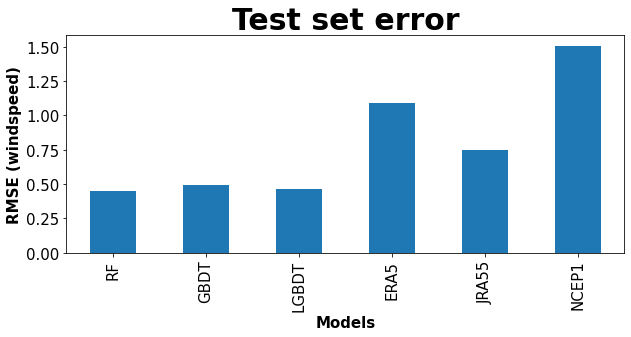

In [42]:
# Section 4: Building synthetic timeseries

try:

    main_functon_3_build_syn_timeseries(X_train, y_train, X_test, y_test, input_data,
                                       n_iter_RF,n_iter_GBDT,n_iter_LGBDT,n_jobs)

except NameError:
    
    print("Above section is not excecuted or an error occured in its execution")
